In [5]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from swiss_rounds_simulator.utils import simulate_tournament, simulate_n_tournaments, compare_settings
from swiss_rounds_simulator.utils import  initiate_league, assign_opponents, play_round


New LDC format places of interest :
* The 8 first teams qualify directly to round of 16
* From 9 to 24 : pseudo round of 32
* Interesting teams : i (9th) and y(25th)  

Format :
* 36 teams,
* 8 games,
* Hat determination of the first 2 games

LoL :
* 16 teams,
* Top 8 to Quarter finales,
* 6 games (not exactly, teams with 3 win qualifies, team with 3 loss gets eliminated)


In [2]:
n_teams = 18
n_rounds = 6

lt = simulate_tournament(nb_teams=n_teams, nb_games=n_rounds, method='probabilistic', delta_level='linear', verbose = False)
for i in range(n_rounds+1):
    sub_lt = lt.query(f"Nb_win == {n_rounds-i}")
    if sub_lt.shape[0] != 0:
        display(sub_lt)

,Id,Level,Strategy,Nb_win,Nb_loss,Win_rate,OWR,R1_opponent,R1_result,R2_opponent,R2_result,R3_opponent,R3_result,R4_opponent,R4_result,R5_opponent,R5_result,R6_opponent,R6_result,Rank
c,2,0.888889,[],5,1,0.83,0.50,g,Win,f,Loss,n,Win,o,Win,q,Win,e,Win,1
e,4,0.777778,[],5,1,0.83,0.61,l,Win,n,Win,f,Win,b,Win,d,Win,c,Loss,2
d,3,0.833333,[],5,1,0.83,0.58,k,Win,a,Win,g,Win,f,Win,e,Loss,b,Win,3


,Id,Level,Strategy,Nb_win,Nb_loss,Win_rate,OWR,R1_opponent,R1_result,R2_opponent,R2_result,R3_opponent,R3_result,R4_opponent,R4_result,R5_opponent,R5_result,R6_opponent,R6_result,Rank
b,1,0.944444,[],4,2,0.67,0.53,r,Win,q,Win,o,Win,e,Loss,j,Win,d,Loss,4
f,5,0.722222,[],4,2,0.67,0.64,a,Win,c,Win,e,Loss,d,Loss,o,Win,q,Win,5
j,9,0.5,[],4,2,0.67,0.44,i,Loss,r,Win,m,Win,h,Win,b,Loss,k,Win,6
h,7,0.611111,[],4,2,0.67,0.47,q,Loss,m,Win,k,Win,j,Loss,a,Win,o,Win,7


,Id,Level,Strategy,Nb_win,Nb_loss,Win_rate,OWR,R1_opponent,R1_result,R2_opponent,R2_result,R3_opponent,R3_result,R4_opponent,R4_result,R5_opponent,R5_result,R6_opponent,R6_result,Rank
q,16,0.111111,[],3,3,0.5,0.61,h,Win,b,Loss,i,Win,g,Win,c,Loss,f,Loss,8
k,10,0.444444,[],3,3,0.5,0.53,d,Loss,p,Win,h,Loss,l,Win,i,Win,j,Loss,9
a,0,1.0,[],3,3,0.5,0.44,f,Loss,d,Loss,r,Win,p,Win,h,Loss,g,Win,10
i,8,0.555556,[],3,3,0.5,0.44,j,Win,o,Loss,q,Loss,n,Win,k,Loss,m,Win,11


,Id,Level,Strategy,Nb_win,Nb_loss,Win_rate,OWR,R1_opponent,R1_result,R2_opponent,R2_result,R3_opponent,R3_result,R4_opponent,R4_result,R5_opponent,R5_result,R6_opponent,R6_result,Rank
g,6,0.666667,[],2,4,0.33,0.56,c,Loss,l,Win,d,Loss,q,Loss,n,Win,a,Loss,12
n,13,0.277778,[],2,4,0.33,0.50,m,Win,e,Loss,c,Loss,i,Loss,g,Loss,p,Win,13
o,14,0.222222,[],2,4,0.33,0.58,p,Win,i,Win,b,Loss,c,Loss,f,Loss,h,Loss,14
m,12,0.333333,[],2,4,0.33,0.42,n,Loss,h,Loss,j,Loss,r,Win,l,Win,i,Loss,15
l,11,0.388889,[],2,4,0.33,0.36,e,Loss,g,Loss,p,Win,k,Loss,m,Loss,r,Win,16


,Id,Level,Strategy,Nb_win,Nb_loss,Win_rate,OWR,R1_opponent,R1_result,R2_opponent,R2_result,R3_opponent,R3_result,R4_opponent,R4_result,R5_opponent,R5_result,R6_opponent,R6_result,Rank
p,15,0.166667,[],1,5,0.17,0.33,o,Loss,k,Loss,l,Loss,a,Loss,r,Win,n,Loss,17


,Id,Level,Strategy,Nb_win,Nb_loss,Win_rate,OWR,R1_opponent,R1_result,R2_opponent,R2_result,R3_opponent,R3_result,R4_opponent,R4_result,R5_opponent,R5_result,R6_opponent,R6_result,Rank
r,17,0.055556,[],0,6,0.0,0.44,b,Loss,j,Loss,a,Loss,m,Loss,p,Loss,l,Loss,18


In [7]:
simu = simulate_n_tournaments(n_tournaments=10,nb_teams=n_teams, nb_games= n_rounds, delta_level='linear')
simu

,Level,Strategy,Avg_WR,Avg_Rank
f,0.72,[],0.65,5.2
d,0.83,[],0.68,5.3
g,0.67,[],0.62,5.6
b,0.94,[],0.67,5.8
a,1.00,[],0.65,6.3
c,0.89,[],0.62,6.4
e,0.78,[],0.58,7.4
k,0.44,[],0.53,8.2
h,0.61,[],0.55,8.6
j,0.50,[],0.50,9.5


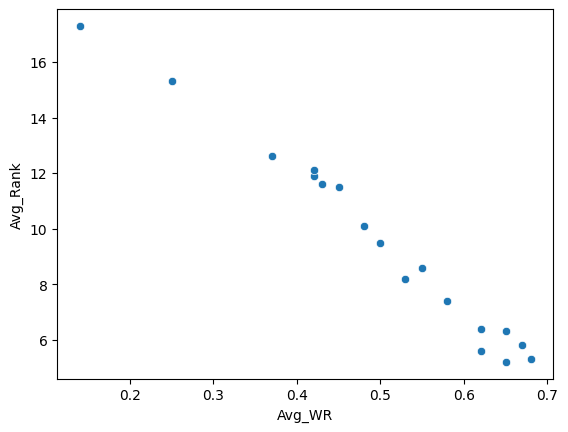

In [8]:
sns.scatterplot(data=simu, x='Avg_WR', y='Avg_Rank');

In [4]:
comp = False
if comp :
    compare_settings(n_tournaments=100, 
                 n_teams=18, 
                 n_rounds = 6, 
                 delta_level ='linear',
                 strategies={'m':[1]}, 
                 probabilistic=True, 
                 deterministic=True)
